# LAB 2: Трансформация сферы в модель (деформации)
### 3D Machine Learning // Suchkova Natalia М8О - 214М - 22
10.12.23 @ MAI IT-Center

**ПОСОБИЕ**

- https://habr.com/ru/companies/itmai/articles/504416/
- https://pytorch3d.org/tutorials/render_textured_meshes

  
**The Task**

1. Выбрать не слишком простую геометрически 3D-модель
2. Реализовать трансформацию сферы в выбранную модель

In [11]:
# pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable"

In [2]:
# import sys
# import torch
# pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
# version_str="".join([
#     f"py3{sys.version_info.minor}_cu",
#     torch.version.cuda.replace(".",""),
#     f"_pyt{pyt_version_str}"
# ])
# !pip install fvcore iopath
# !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

AttributeError: 'NoneType' object has no attribute 'replace'

In [1]:
import os
import pathlib
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from tqdm import tqdm_notebook
from celluloid import Camera

import torch

# untilities 
from pytorch3d.utils import ico_sphere

# loss functions and regulaziers
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency
)

# io utils
from pytorch3d.io import load_obj

# operations with data
from pytorch3d.ops import sample_points_from_meshes

# datastructures
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex, Textures

# transforms
from pytorch3d.transforms import Transform3d, RotateAxisAngle

# render 
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader
)

import trimesh
from trimesh import registration
from trimesh import visual

# If you have got a CUDA device, you can use GPU mode
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)
else:
    device = torch.device('cpu')

In [2]:
# mesh in pytorch3d
path_to_model = 'models\star-wars-grogu\source\Grogu\Grogu_rotated.obj'
verts, faces_idx, _ = load_obj(path_to_model)
faces = faces_idx.verts_idx

# крутим модель --------------------------------------------- 
# rot = RotateAxisAngle(-30, 'Z', True)
# rot = Transform3d().rotate_axis_angle(-90, 'Y', True)\
#                    .rotate_axis_angle(140, 'Z', True)\
#                    .rotate_axis_angle(-150, 'X', True)\
#                    .rotate_axis_angle(75, 'Y', True)\
#                    .rotate_axis_angle(75, 'Y', True

# verts = rot.transform_points(verts)    # => (N, P, 3)
# -----------------------------------------------------------

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the grogu.
grogu_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

# Sphere mesh in pytorch3d
sphere_mesh = ico_sphere(4, device)
verts_rgb = torch.ones_like(sphere_mesh.verts_list()[0])[None]
sphere_mesh.textures = Textures(verts_rgb=verts_rgb.to(device))

# Mesh to pointcloud with normals in pytorch3d
num_points_to_sample = 25000

grogu_vert, grogu_norm = sample_points_from_meshes(
    grogu_mesh,
    num_points_to_sample ,
    return_normals=True
)

sphere_vert, sphere_norm = sample_points_from_meshes(
    sphere_mesh,
    num_points_to_sample,
    return_normals=True
)

def convert_to_mesh(mesh):
    """Trimesh может загружать сцены вместо монолитного объекта
    """
    if isinstance(mesh, trimesh.Scene):
        return mesh.dump(concatenate=True)
    else:
        return mesh

def scale_to_unit(mesh: trimesh.Trimesh):
    length, weight, height = mesh.extents
    scale = 1 / max(length, weight, height)
    mesh.apply_scale((scale, scale, scale))

path_to_sphere = 'models\sphere.obj'
mesh_target = convert_to_mesh(trimesh.load_mesh(str(path_to_model)))
mesh_source = convert_to_mesh(trimesh.load_mesh(str(path_to_sphere)))

mesh_target.rezero()
mesh_source.rezero()
scale_to_unit(mesh_target)
scale_to_unit(mesh_source)

mesh_source.visual = visual.ColorVisuals(mesh_source, vertex_colors=(255, 0, 0, 255))
mesh_target.visual = visual.ColorVisuals(mesh_target, vertex_colors=(0, 255, 0, 255))

scene = trimesh.Scene([mesh_source, mesh_target])

In [3]:
# надо покрутить йоду чтобы он попал в кадр
# mesh = trimesh.load('models\star-wars-grogu\source\Grogu\Grogu.obj')
# angle = - math.pi / 2
# direction = [1, 0, 1]
# center = [0, 1, 0]

# rot_matrix = trimesh.transformations.rotation_matrix(angle, direction, center)
# mesh.apply_transform(rot_matrix)

# angle = math.pi * 0.9
# direction = [0, 1, 0]
# center = [0, 0, 0]

# rot_matrix = trimesh.transformations.rotation_matrix(angle, direction, center)
# mesh.apply_transform(rot_matrix)

# mesh.show()

In [4]:
%%time
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0, 
    faces_per_pixel=1, 
)

# We can add a directional light in the scene. 
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
        )
)

CPU times: total: 0 ns
Wall time: 2.99 ms


In [5]:
%%time
# Select the viewpoint using spherical angles  
distance = 2.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device, at=((-0.02, 0.1, 0.0), ))

# Render the grogu providing the values of R and T. 
image_grogu = phong_renderer(meshes_world=grogu_mesh, R=R, T=T)
image_sphere = phong_renderer(meshes_world=sphere_mesh, R=R, T=T)

image_sphere = image_sphere.cpu().numpy()
image_grogu = image_grogu.cpu().numpy()

CPU times: total: 1h 14min 58s
Wall time: 20min 19s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


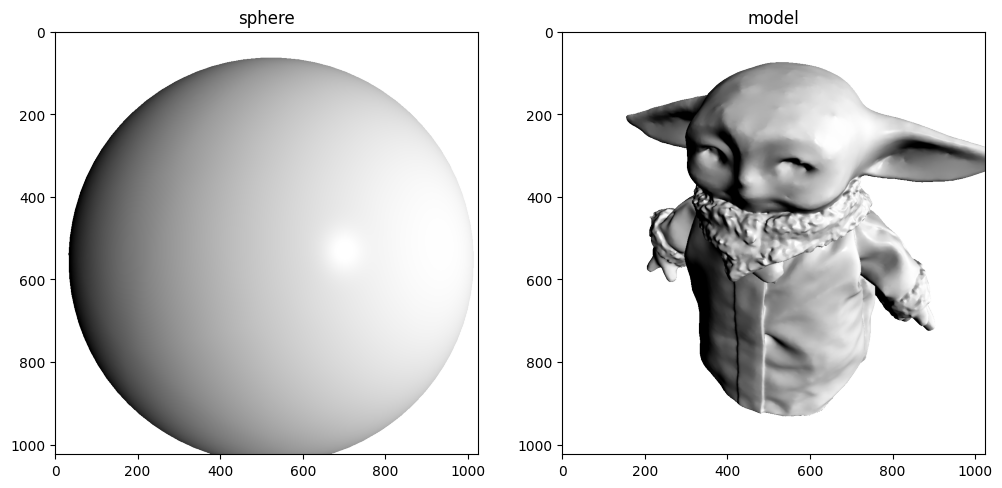

In [6]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(image_sphere.squeeze())
plt.grid(False)
plt.title('sphere')

plt.subplot(122)
plt.imshow(image_grogu.squeeze())
plt.grid(False)
plt.title('model')
plt.show()

In [7]:
# plt.figure(figsize=(7, 7))
# plt.imshow(image_sphere.squeeze())
# plt.grid(False)

# # Target mesh of grogu
# plt.imshow(image_grogu.squeeze())
# plt.grid(False)

In [8]:
deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [9]:
# Number of optimization steps
Niter = 5000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 50

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

C:\Users\User\AppData\Local\Temp\ipykernel_3056\2308346913.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(Niter))


  0%|          | 0/5000 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\new_pyt\lib\site-packages\pytorch3d\ops\laplacian_matrices.py:49: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:607.)
  A = torch.sparse.FloatTensor(idx, ones, (V, V))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping 

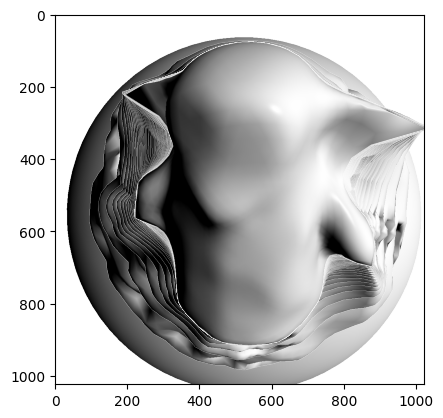

In [10]:
loop = tqdm_notebook(range(Niter))

fig = plt.figure()
camera = Camera(fig)

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = sphere_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(grogu_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)

    # Plot mesh
    if i % plot_period == 0 or i==0:

        # Render the grogu providing the values of R and T. 
        image_grogu = phong_renderer(meshes_world=new_src_mesh, R=R, T=T)
        image_grogu = image_grogu.detach().cpu().numpy()

        plt.imshow(image_grogu.squeeze())
        plt.grid(False)
        camera.snap()

    # Optimization step
    loss.backward()
    optimizer.step()

In [11]:
from IPython.display import HTML
animation = camera.animate()
HTML(animation.to_html5_video())

In [13]:
animation.save('grogu_transform.mp4')

Text(0.5, 1.0, 'Loss vs iterations')

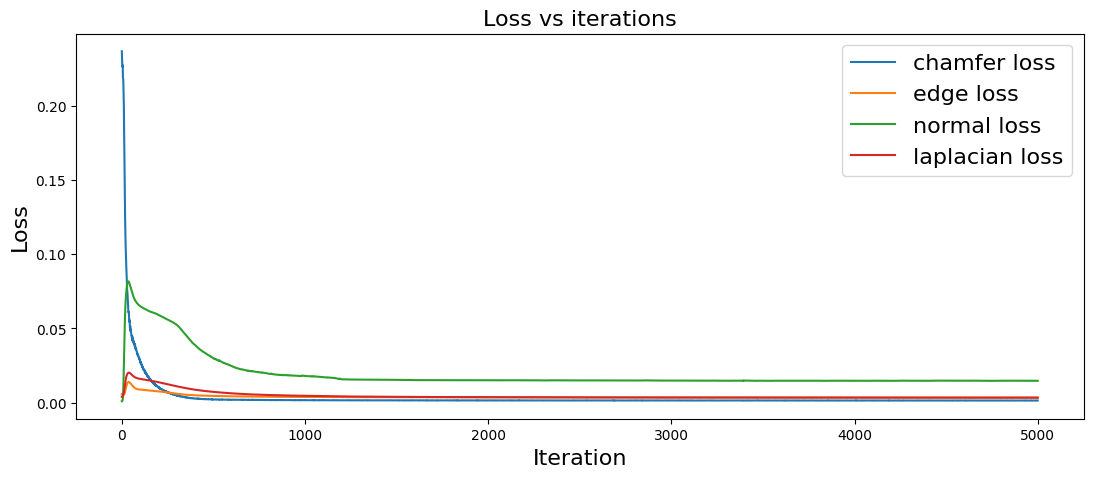

In [12]:
# Losses evaluation
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot([x.detach().numpy() for x in chamfer_losses], label="chamfer loss")
ax.plot([x.detach().numpy() for x in edge_losses], label="edge loss")
ax.plot([x.detach().numpy() for x in normal_losses], label="normal loss")
ax.plot([x.detach().numpy() for x in laplacian_losses], label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")